# Practical session 3 - Brownian motion, Fourier transform

Students (pair):
- [Student 1]([link](https://github.com/username1))
- [Student 2]([link](https://github.com/username2))

```
conda create --name=lab3 --file=requirement.txt
conda activate lab3
# do not forget to deactivate the environment if needed
# you can remove the environment once you are done
conda env remove --name=lab3
```

In [ ]:
%load_ext autoreload
%autoreload 2

## <a name="ex1">Exercise 1: Brownian motion</a>

This first exercise consists in generating a Brownian motion on the closed unit ball $\mathcal{B}(\mathbf{0}, 1) = \{ \mathbf{x} \mid \Vert \mathbf{x} \Vert  \leq 1\}$, focusing first on the 2-D case. The Brownian motion is a random walk with independent, identically distributed Gaussian increments, appearing for instance in thermodynamics and statistical mechanics (to model the evolution of a large particle in a medium composed of a large number of small particles, ...). It is also connected to the diffusion process (Einstein).

Let $N \in \mathbb{N}^*$, $\delta > 0$, and $\mathbf{x} = (x_1, x_2) \in  \mathcal{B}(\mathbf{0}, 1)$. The first $N$ steps of a 2-D discrete-time Brownian motion $W$ can be generated as follows

\begin{align*}
    W_0 &= \mathbf{x}, \\
    %
    (\forall n \in \{1, \dotsc, N-1 \}), \quad W_n &= W_{n−1} + \sqrt{\delta} G_n, \quad G_n \sim \mathcal{N}(\mathbf{0}, \mathbf{I}),
\end{align*}

where $\mathcal{N}(\mathbf{0}, \mathbf{I})$ is a Gaussian distribution with mean $\mathbf{0}$ and identity covariance matrix.

1. Define a random generator `rng`, set to a known state for reproducibility (see session 2).

**Answer:**

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats



In [36]:
# Set a seed value (you can use any integer)
seed_value = 42

# Initialize the random number generator with the seed
np.random.seed(seed_value)

In [44]:
mean, cov = np.zeros(2), np.eye(2)   # mean = [0, 0] cov = I2

# create an instance of generator following a gamme distribution

rng = np.random.default_rng(seed=42).multivariate_normal(mean, cov, 1000)

2. Implement a function `brownian_motion(niter, x, step, rng)` which

    - simulates $W$ until it reaches the boundary of $\mathcal{B}(\mathbf{0}, 1)$, using a maximum of $N$ iterations (`niter`), a starting point $\mathbf{x} \in \mathcal{B}(\mathbf{0}, 1)$ (`x`) and step-size $\delta$ (`step`);
    - interpolates linearly between the two last positions to determine the points $W^*$ where the trajectory crosses the boundary (if applicable);
    - returns both the whole random walk $W$ and, if appropriate, the point at the intersection between the last segment of the trajectory and $\mathcal{B}(\mathbf{0}, 1)$.
 
> Hint: 
> - you can easily derive a closed form expression for $W^*$, observing that $\Vert W^* \Vert^2= 1$ and $W^* \in [W_{n-1}, W_n]$. 
> - you can also take a look at [`np.roots`](https://numpy.org/doc/stable/reference/generated/numpy.roots.html?highlight=roots#numpy.roots) if needed.

> Recall of the Linear Interpolation (LERP) for $n$-dimensional vectors:
> - Clearly, $\vec{D}=\alpha \vec{C}$ with $\alpha \in [0, 1]$ and hence $\vec{P}-\vec{B}= \alpha (\vec{A}-\vec{B})$ which is equivalent to $\vec{P}= (1-\alpha) \vec{B} + \alpha \vec{A}$. 
![alternatvie text](img/for_Course.png)

**Answer:**

To find W * where the trajectory crosses the boundary.
On considère 2 points Wn-1 (Xn-1, Yn-1) et Wn (Xn, Yn), avec la norme de Wn>1 et la norme de Wn-1<1. On cherche les coordonnées (x, y) du point d'intersecion entre la droite passant par Wn et Wn-1 et le cercle d'équation (1) x^2 + y^2 = 1.
L'équation de la droite est donnée par (2) y = ax + b avec a = (Yn - Yn-1)/(Xn - Xn-1) et b = Yn-1 - Xn-1*((Yn - Yn-1)/(Xn - Xn-1)).
En mettant (2) au carré on obtient (3) 0 = (a^2 + 1)* x^2 + 2ab * x + b^2 -1, on obtient y en résolvant l'équation (3).

In [90]:
# your code

def verif_racine(x, a, b):
    if  min(a, b) <= x[0]<= max(a, b) : 
        return x[0]
    if min(a, b) <= x[1]<= max(a, b) :
        return x[1]

def brownian_motion(niter, x, step, rng):
    W_0 = x
    
    W = [] # W is the list to save the coordonates of each point of the random walk
    
    W_iter = W_0
    
    print(f"Wx_n = {W_iter[0]}\nWy_n = {W_iter[1]}\nW_n  = {W_iter}")

    
    for i in range(1, niter):
        
        if np.sqrt(W_iter[0]**2 + W_iter[1]**2) < 1:
            W.append(W_iter)
            print(f"Wx_n-1 = {W[-1][0]}\nWy_n-1 = {W[-1][1]}\nW_n-1 = {W[-1]}")
            W_iter = W_iter + np.sqrt(step)* rng[i]
            print(f"Wx_n = {W_iter[0]}\nWy_n = {W_iter[1]}\nW_n  = {W_iter}")
            
        else:
            # retrieve Wn-1 from the list W
            # W[-1][1] is the x coordonnate of Wn-1 and W[-1][0] is the y coordonnate of Wn-1
            x_a, x_b, y_a, y_b = W_iter[0],W[-1][0],W_iter[1],W[-1][1]
            a = (y_a - y_b)/(x_a - x_b)
            b = (x_a * y_b - x_b * y_a)/(x_a - x_b)
            #b = W[-1][1] - W[-1][0]*((W_iter[1] - W[-1][1])/(W_iter[0]- W[-1][0]))
            #b = 
            # p0, p1, p2  correspondent aux coefficients du polynôme de degré 2 obtenu dans l'équation (3)
            p = np.empty(3)
            p[2] = b**2 -1
            p[1] = 2 * a * b
            p[0] = a**2 + 1
            print(p)
            x = np.roots(p)
            print(f"x : {x}")
            x_possible = verif_racine(x, x_a, x_b)# attention il peut y avoir 3 cas 0, 1, 2 racines
            print(f"x_possible : {x_possible}\na = {min(x_a, x_b)}\nb = {max(x_a, x_b)}")
            #chosir toujours la racine entre X(Wn) X(Wn_1)
            y_possible = a*x_possible + b
            
            # Calcul de la norme L2 (euclidienne)
            norme_l2 = np.sqrt(x_possible**2 + y_possible**2)

            # Vérification avec assert
            assert np.isclose(norme_l2, 1.0), "La norme L2 n'est pas égale à 1"

            # Si la norme est égale à 1, le test réussit, sinon une AssertionError est levée.
            print("Le test a réussi : la norme L2 est égale à 1.")
            
            break
            
    return W, (x, y)


In [91]:
# your code
rw_W, cross_point = brownian_motion(niter = 1000, x = [0.2, 0.4], step = 10e-2, rng =rng)

Wx = [coordinates[0] for coordinates in rw_W]
Wy = [coordinates[1] for coordinates in rw_W]


Wx_n = 0.2
Wy_n = 0.4
W_n  = [0.2, 0.4]
Wx_n-1 = 0.2
Wy_n-1 = 0.4
W_n-1 = [0.2, 0.4]
Wx_n = 0.4373135051545406
Wy_n = 0.6974326790586544
W_n  = [0.43731351 0.69743268]
Wx_n-1 = 0.4373135051545406
Wy_n-1 = 0.6974326790586544
W_n-1 = [0.43731351 0.69743268]
Wx_n = -0.17965799397370208
Wy_n = 0.2856473626506758
W_n  = [-0.17965799  0.28564736]
Wx_n-1 = -0.17965799397370208
Wy_n-1 = 0.2856473626506758
W_n-1 = [-0.17965799  0.28564736]
Wx_n = -0.13923130887341953
Wy_n = 0.18564267415449123
W_n  = [-0.13923131  0.18564267]
Wx_n-1 = -0.13923130887341953
Wy_n-1 = 0.18564267415449123
W_n-1 = [-0.13923131  0.18564267]
Wx_n = -0.1445443013774978
Wy_n = -0.0841135013763313
W_n  = [-0.1445443 -0.0841135]
Wx_n-1 = -0.1445443013774978
Wy_n-1 = -0.0841135013763313
W_n-1 = [-0.1445443 -0.0841135]
Wx_n = 0.1335457556531059
Wy_n = 0.1618459047902777
W_n  = [0.13354576 0.1618459 ]
Wx_n-1 = 0.1335457556531059
Wy_n-1 = 0.1618459047902777
W_n-1 = [0.13354576 0.1618459 ]
Wx_n = 0.15442649563142272
Wy_n = 0.51

In [52]:
x = np.array([0.5, 0.7])
a = 0.3
b = 0.6
print(verif_racine(x, a, b))

0.5


3. Diplay the trajectory of a Brownian motion starting from $\mathbf{x} = (0.2, 0.4)$, using $\delta = 10^{-2}$, $N = 1000$. Display the unit circle on the same figure, and highlight the intersection with the boundary of the domain (whenever it exists).

> Hint: to draw the unit disk, you can use for instance:
> ```python
> circle = plt.Circle((0,0), 1)
> fig, ax = plt.subplots()
> plt.xlim(-1.25,1.25)
> plt.ylim(-1.25,1.25)
> plt.grid(linestyle = "--", zorder = 1)
> ax.set_aspect(1)
> ax.add_artist(circle)
> ```

**Answer:**

In [47]:
x = [0.2, 0.4]
res = x + 10*rng[0]
print(res)

[ 3.2471708  -9.99984106]


In [49]:
coeff = [2, 2, 1]
np.roots(coeff)


array([-0.5+0.5j, -0.5-0.5j])

11 11


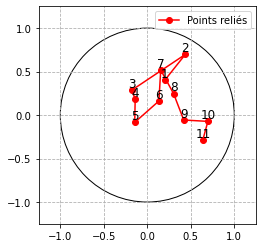

In [96]:
# Création du cercle
circle = plt.Circle((0, 0), 1, fill= False)

# Création de la figure et des axes
fig, ax = plt.subplots()
plt.xlim(-1.25, 1.25)
plt.ylim(-1.25, 1.25)
plt.grid(linestyle="--", zorder=1)
ax.set_aspect(1)

# Ajout du cercle à l'axe
ax.add_artist(circle)

print(len(Wx), len(Wy))

# Relier les points à l'intérieur du cercle
plt.plot(Wx, Wy, marker='o', linestyle='-', color='red', label='Points reliés')

# Affichage des points à l'intérieur du cercle avec des numéros
for i, (x, y) in enumerate(zip(Wx, Wy), start=1):
    plt.scatter(x, y, c='red', marker='.')
    plt.text(x, y, str(i), fontsize=12, ha='center', va='bottom')
    
# Légende
plt.legend()

# Afficher le graphique
plt.show()



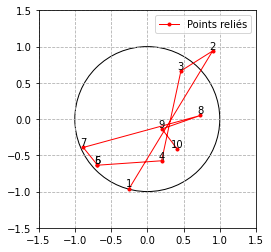

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Création du cercle non rempli
circle = plt.Circle((0, 0), 1, fill=False)

# Création de la figure et des axes
fig, ax = plt.subplots()
plt.xlim(-1.5, 1.5)  # Réduire la plage d'affichage en X
plt.ylim(-1.5, 1.5)  # Réduire la plage d'affichage en Y
plt.grid(linestyle="--", zorder=1)
ax.set_aspect(1)

# Ajout du cercle à l'axe
ax.add_artist(circle)

# Génération de données aléatoires pour le nuage de points
np.random.seed(42)
num_points = 10
x_points = np.random.uniform(-1, 1, num_points)
y_points = np.random.uniform(-1, 1, num_points)


# Relier les points à l'intérieur du cercle avec une ligne plus fine
plt.plot(x_points, y_points, marker='o', linestyle='-', color='red', markersize=3, linewidth=1, label='Points reliés')

# Affichage des points à l'intérieur du cercle avec des numéros et des points plus petits
for i, (x, y) in enumerate(zip(x_points, y_points), start=1):
    plt.scatter(x, y, c='red', marker='.', s=20)
    plt.text(x, y, str(i), fontsize=10, ha='center', va='bottom')

# Légende
plt.legend()

# Afficher le graphique
plt.show()


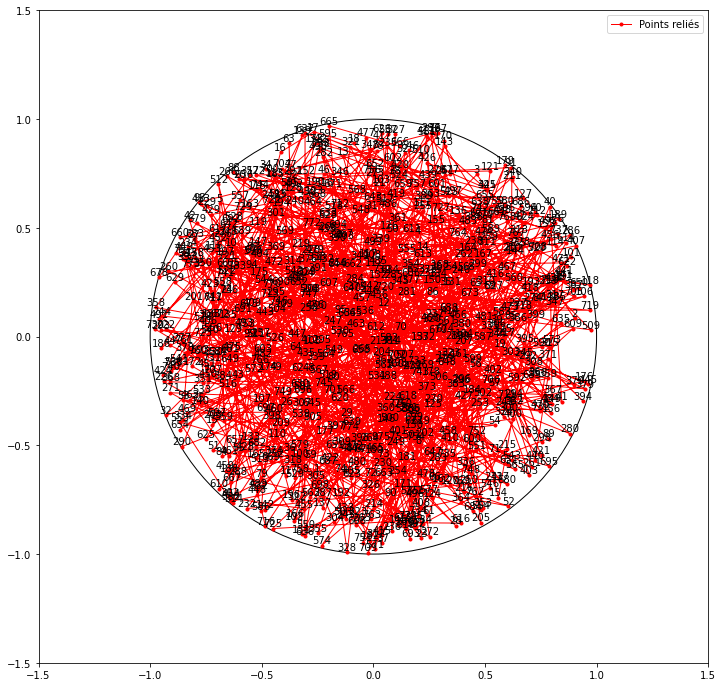

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Création du cercle non rempli
circle = plt.Circle((0, 0), 1, fill=False)

# Création d'une figure avec une taille personnalisée (largeur x hauteur)
fig = plt.figure(figsize=(12, 12))

# Ajout du cercle à l'axe
ax = fig.add_subplot(111)
ax.add_artist(circle)

# Définir la limite des axes pour inclure le cercle
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)

# Génération de données aléatoires pour le nuage de points
np.random.seed(42)
num_points = 1000
x_points = np.random.uniform(-1, 1, num_points)
y_points = np.random.uniform(-1, 1, num_points)

# Filtrer les points à l'intérieur du cercle (rayon <= 1)
indices_a_l_interieur_du_cercle = x_points**2 + y_points**2 <= 1
x_points_interieur = x_points[indices_a_l_interieur_du_cercle]
y_points_interieur = y_points[indices_a_l_interieur_du_cercle]

# Relier les points à l'intérieur du cercle avec une ligne plus fine
plt.plot(x_points_interieur, y_points_interieur, marker='o', linestyle='-', color='red', markersize=3, linewidth=1, label='Points reliés')

# Affichage des points à l'intérieur du cercle avec des numéros et des points plus petits
for i, (x, y) in enumerate(zip(x_points_interieur, y_points_interieur), start=1):
    plt.scatter(x, y, c='red', marker='.', s=20)
    plt.text(x, y, str(i), fontsize=10, ha='center', va='bottom')

# Légende
plt.legend()

# Afficher le graphique
plt.show()



4. Represent, on the same figure, 4 other trajectories of $W$ with the same parameters.

**Answer:**

In [ ]:
# your code

5. [Bonus] Generalize the procedure to a $M$-dimensional Brownian motion, $M > 2$.

**Answer:**

In [ ]:
# your code

---
## <a name="ex2">Exercise 2: 2D Fourier transform, ideal low-pass filter and linear convolution</a>

In this exercise, we explore the use of the 2-dimensional Fourier transform to filter an image, and convolve it with a blurring kernel.

1\. Load and display one of the images contained in the `img/` folder. The image will be denoted by $\mathbf{X} \in \mathbb{R}^{M_1 \times N_1}$ in the rest of this exercise.

**Answer:**

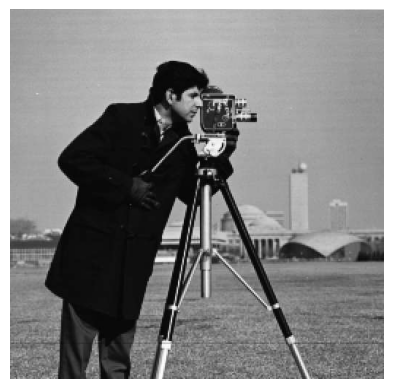

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import cv2
from scipy import fftpack
image = cv2.imread("img/cameraman.png")

# Display the image using Matplotlib
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert from BGR to RGB
plt.axis('off')  # Hide axes
plt.show()

2\. Let $\mathcal{F}$ denote the 2D discrete Fourier transform. Compute $|\mathcal{F}(\mathbf{X})|^2$, the spectrum of the image $\mathbf{X} \in \mathbb{R}^{M_1 \times N_1}$ (i.e., the term-wise squared absolute value of its Fourier transform) loaded in 1. Display the result in logarithmic scale.

a) In this representation, where is the pixel of the spectrum associated with the null frequency located?
    
b) Take a look at the documentation of `np.fft.fftshift`. Use it to ensure that the null frequency is located at the center of the image. 

**Answer:**

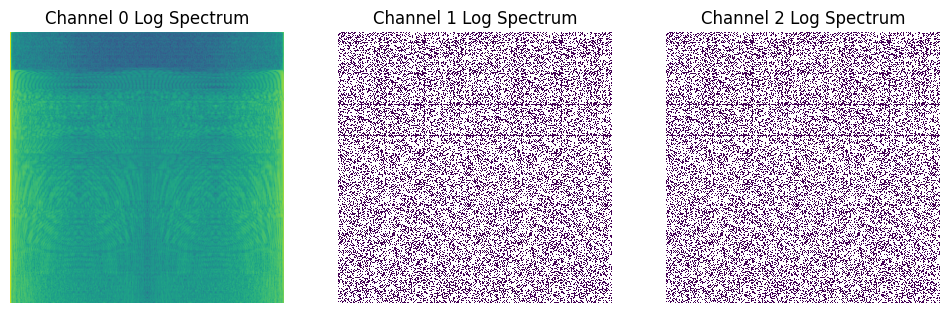

In [130]:
# Compute the 2D discrete Fourier transform (DFT)
dft = np.fft.fft2(image)

# Create a figure with three subplots for each color channel
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
axes[0].imshow(np.abs(dft[:,:,0]), norm=LogNorm())
axes[0].set_title(f'Channel 0 Log Spectrum')
axes[0].axis('off')

axes[1].imshow(np.abs(dft[:,:,1]), norm=LogNorm(vmin=1, vmax = 10))
axes[1].set_title(f'Channel 1 Log Spectrum')
axes[1].axis('off')

axes[2].imshow(np.abs(dft[:,:,2]), norm=LogNorm(vmin=1, vmax = 10))
axes[2].set_title(f'Channel 2 Log Spectrum')
axes[2].axis('off')

plt.show()

a) The output contains the term for zero frequency is in the low-order corner of the transformed axes.

(-0.5, 511.5, 506.5, -0.5)

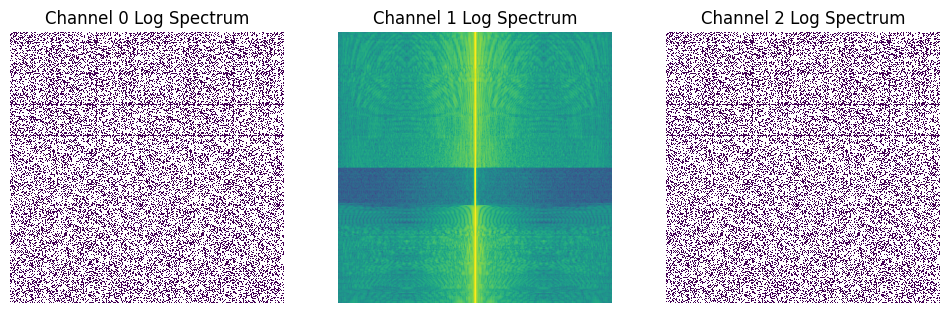

In [131]:
shifted_spectrum = np.fft.fftshift(dft)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
axes[0].imshow(np.abs(shifted_spectrum[:,:,0]), norm=LogNorm(vmin = 1, vmax = 10))
axes[0].set_title(f'Channel 0 Log Spectrum')
axes[0].axis('off')

axes[1].imshow(np.abs(shifted_spectrum[:,:,1]), norm=LogNorm(vmin=1, vmax = 100000))
axes[1].set_title(f'Channel 1 Log Spectrum')
axes[1].axis('off')

axes[2].imshow(np.abs(shifted_spectrum[:,:,2]), norm=LogNorm(vmin=1, vmax = 10))
axes[2].set_title(f'Channel 2 Log Spectrum')
axes[2].axis('off')

3\. 
    a) Create a function `ideal_lowpass_filter` to filter $\mathbf{X}$ by an ideal low-pass filter. The filter preserves Fourier coefficients associated to frequencies below a cutoff specified in each direction ($\mathbf{f}_c = (f_{c,y}, f_{c,x})$), and sets others to zero. For simplicity, $f_{c,y}$ and $f_{c,x}$ can be expressed as a number of samples to be kept along each dimension (e.g., $\mathbf{f}_c = (50,50)$).

b) Display the filtered image for 2 different values of $\mathbf{f}_c$. What do you observe as the cutoff frequencies increase?
    
> Warning: beware the type of the array after `np.fft.fft2`, do not hesitate to specify the type if you make copies from this array
> ```python
> a = np.zeros((2,2), dtype=np.complex)
> ...
> ```

**Answer:**

In [142]:
def ideal_lowpass_filter(img, fx, fy):
    # Compute the 2D discrete Fourier transform (DFT)
    dft = np.fft.fft2(image)
    # Center the spectrum
    shifted_dft = np.fft.fftshift(dft)
    # computer center coordinates
    cx, cy = int(shifted_dft.shape[0]//2), int(shifted_dft.shape[1]//2)
    result = np.zeros(shifted_dft.shape, dtype=complex)
    result[int(cx -fx//2):int(cx +fx//2),int(cy -fy//2):int(cy +fy//2),:] =  shifted_dft[int(cx -fx//2):int(cx +fx//2),int(cy -fy//2):int(cy +fy//2),:]
    # reshift the null frequency to the low-order corner 
    result_shiffted_back = np.fft.ifftshift(result)
    # Computer fourrier transform inverse 
    image_after_filter = np.fft.ifft2(result_shiffted_back).real
    return image_after_filter
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


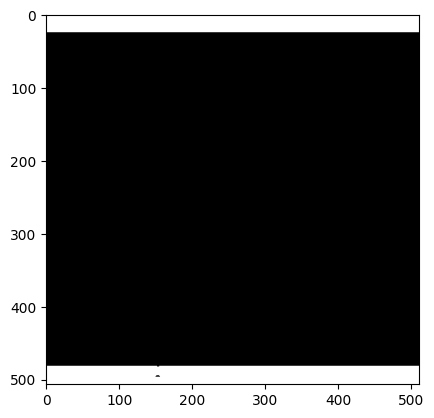

In [155]:
image_post_filter = ideal_lowpass_filter(image, 50,50)

plt.imshow(image_post_filter, cmap= 'gray')  # Convert from BGR to RGB
plt.show()

In [152]:
image_post_filter[:,:,0]

array([[183.42064096, 176.68500743, 170.27144482, ..., 203.41161904,
        197.00049055, 190.26557105],
       [156.55515219, 157.08290765, 157.60200204, ..., 155.12324309,
        155.5566712 , 156.03977239],
       [152.61275375, 153.28222571, 154.0192616 , ..., 151.33290796,
        151.61162998, 152.04587386],
       ...,
       [127.47800858, 125.75823781, 124.02895684, ..., 131.09265245,
        130.27824421, 129.0328475 ],
       [121.62231563, 121.85375094, 122.72054524, ..., 123.76693933,
        122.71848981, 121.95100709],
       [121.90580993, 122.67274053, 124.06825628, ..., 122.7449097 ,
        122.04864869, 121.7267939 ]])

4\. Let $\mathbf{H} \in \mathbb{R}^{M_2\times N_2}$ be a 2-D Gaussian kernel, obtained as the outer product of two 1-D Gaussian windows $\mathbf{w}_y \in \mathbb{R}^{M_2}$ and $\mathbf{w}_x \in \mathbb{R}^{N_2}$, of standard deviation $\sigma_y = 10$ and $\sigma_x = 10$, respectively:

\begin{equation}
    \mathbf{H} = \mathbf{w}_y \mathbf{w}_x^T.
\end{equation}

Let $M = M_1+M_2-1$ and $N =  N_1+N_2-1$. From the discrete convolution theorem, the linear convolution between $\mathbf{H}$ and $\mathbf{X}$ can be computed as follows

\begin{equation}
    \mathbf{X} \star \mathbf{H} = \mathcal{F}^{-1} \Big( \mathcal{F}\big(P_1(\mathbf{X})\big) \odot \mathcal{F}\big(P_2(\mathbf{H})\big) \Big) \in \mathbb{R}^{M\times N},
\end{equation}

where $P_i: \mathbb{R}^{M_i \times N_i} \rightarrow \mathbb{R}^{M \times N}$, $i \in \{1, 2\}$, are 0-padding operators, $\odot$ is the Hadamard (= term-wise) product, $\mathcal{F}^{-1}$ is the 2D discrete inverse Fourier transform.

Compute and display $\mathbf{X} \star \mathbf{H}$, for $M_2 = N_2 = 10$. What do you observe?

> Hint: 
> - the usual 0-padding procedure in image space consists in appending trailing zeros. For instance (in 1D), 0-padding a vector $\mathbf{x} \in \mathbb{R}^N_1$ to the size $N>N_1$ corresponds to creating the vector
\begin{bmatrix}
\mathbf{x} \\
\mathbf{0}_{N-N_1}
\end{bmatrix}
> - since the input images are real, $\mathcal{F}(\mathbf{x})$ and $\mathcal{F}(\mathbf{h})$ are Hermitian symmetric. In this case, a more efficient version of `np.fft.fft2` can be used, computing only quarter of the Fourier coefficients (half of the Fourier coefficients in each direction): [`np.fft.rfft2`](https://numpy.org/doc/stable/reference/generated/numpy.fft.rfft2.html?highlight=rfft#numpy.fft.rfft2). Its inverse, [`np.fft.irfft2`](https://numpy.org/doc/stable/reference/generated/numpy.fft.irfft2.html#numpy.fft.irfft2), also ensures that the output is real;
> - the 2D Gaussian window can be generated as the outer product of two 1D Gaussian windows (one window for each dimension);
> - you can take a look at [scipy.signal.windows.gaussian](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.gaussian.html#scipy.signal.windows.gaussian) and [np.newaxis](https://numpy.org/doc/stable/reference/constants.html?highlight=newaxis#numpy.newaxis) (or `np.reshape` or built-in `np.outer`).

**Answer:**

In [ ]:
# your code